In [1]:
import os
import scipy.stats as stats
import pandas as pd
import numpy as np
import tqdm
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from collections import defaultdict

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
fontpath = os.path.expanduser('~/Downloads/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 16,
    'axes.labelsize': 16,
    'font.size': 16,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': prop.get_name(),
    'text.usetex': True
}

mpl.rcParams.update(params)

In [3]:
AVAILBLE_DATASETS = ['DIALOG_pc.csv','DIALOG_tc.csv','FLICKR.csv','MLQE.csv','REAL_SUM.csv',
                     'SUM_EVAL.csv','TAC_08.csv','TAC_09.csv','TAC_11.csv']
DATA_PATH = 'final_df'

In [4]:
def load_csv(dataset):
    dd = pd.read_csv(os.path.join(DATA_PATH, dataset))
    if dataset == 'FLICKR.csv':
        dd[['System','Utterance']] = dd[['Utterance', 'System']]
    return dd.set_index(['System','Utterance'])

In [5]:
datasets = {}
for d in AVAILBLE_DATASETS:
    datasets[d] = load_csv(d)

In [24]:
def normalize_dataset_names(d):
    if d == 'DIALOG_pc.csv':
        return 'Dialog-PC'
    elif d == 'DIALOG_tc.csv':
        return 'Dialog-TC'
    elif d == "SUM_EVAL.csv":
        return 'SUM-EVAL'
    elif d == "TAC_08.csv":
        return 'TAC-08'
    elif d == "TAC_09.csv":
        return 'TAC-09'
    elif d == "TAC_11.csv":
        return 'TAC-11'
    elif d == "REAL_SUM.csv":
        return 'REAL-SUM'
    elif d == "MLQE.csv":
        return 'MLQE'
    elif d == "FLICKR.csv":
        return 'FLICKR'

## Figure 1

In [15]:
METRIC_ORDER = ['BLEU', 'ROUGE', 'JS', 'WE', 'Chrfpp', 'S3', 'MoverScore', 'BERTScore']

In [20]:
def select_utterances(df, indices):
    keep = []
    for _, t in df.groupby(level=0):
        if list(t.index.get_level_values(0))[0] in indices:
            keep.append(t)
    return pd.concat(keep, axis=0)
        
def fit(df, feature_set, target):
    utterances = list(set(df.index.get_level_values(0)))
    
    feature_df = df[feature_set]
    # print(feature_df.head())
    target_df = df[target]
    
    scores = []
    kf = KFold(n_splits=5)
    for train_idx, test_idx in kf.split(utterances):
        # print(train_idx)
        X_train = select_utterances(feature_df, train_idx)
        Y_train = select_utterances(target_df, train_idx)
        
        X_test = select_utterances(feature_df, test_idx)
        Y_test = select_utterances(target_df, test_idx)
        
        clf = GradientBoostingRegressor()
        # clf = DecisionTreeRegressor()
        clf.fit(X_train.values, Y_train.values)
        
        local_scores = []
        for test_i in test_idx:
            X_test_utt = select_utterances(feature_df, [test_i])
            Y_test_utt = select_utterances(target_df, [test_i])
            
            pred_Y = clf.predict(X_test_utt.values)
            l_s = stats.kendalltau(pred_Y, Y_test_utt.values)[0]
            if np.isnan(l_s):
                # print(f"-- {test_i}: {pred_Y}, {Y_test_utt}")
                if len(set(pred_Y)) == len(set(Y_test_utt.values)):
                    l_s = 1.
                else:
                    l_s = 0.
            local_scores.append(l_s)
        scores.append(np.mean(local_scores))
    return np.mean(scores)

In [21]:
def track_fitness_improvement(df, target, order_metrics):
    def fix_JS(m):
        if m == 'JS-2':
            return 'JS_2'
        
    res = {}
    for i, m in enumerate(order_metrics):
        features = order_metrics[:i+1]
        current_score = np.abs(fit(df, features, target))
        prev_max = 0 if res == {} else max(list(res.values()))
        to_append = max(current_score, prev_max)
        print(f' ===== {features}: {to_append}')
        res[m.upper()] = min(to_append, 1)
    return res

In [22]:
def mod(m):
    if 'WE' in m:
        return 'WE'
    return m
    
def compute_tracking(key):    
    df = datasets[key]
    
    ordered_metrics = []
    for o_m in METRIC_ORDER:
        current_ms = [m for m in df.columns if o_m.upper() in m.upper()]
        ordered_metrics.extend(current_ms)
    
    human_metrics = [hm for hm in df.columns if hm.startswith('H:')]
    res = {}
    for t in human_metrics:
        print(f' -- {t}')
        res[t] = track_fitness_improvement(df, t, ordered_metrics)
    return res#, comple

In [23]:
fit_analysis = {}
for k in AVAILBLE_DATASETS:
    # if k != 'DIALOG_pc.csv':
    #     continue
    print(k)
    res = compute_tracking(k)
    fit_analysis[k] = {'fitness': res}

DIALOG_pc.csv
 -- H:engaging
 ===== ['BLEU']: 0.11256615999970834
 ===== ['BLEU', 'ROUGE_WE_1']: 0.11256615999970834
 ===== ['BLEU', 'ROUGE_WE_1', 'ROUGE_WE_2']: 0.11256615999970834
 ===== ['BLEU', 'ROUGE_WE_1', 'ROUGE_WE_2', 'ROUGE_L']: 0.11374919356948907
 ===== ['BLEU', 'ROUGE_WE_1', 'ROUGE_WE_2', 'ROUGE_L', 'ROUGE_1']: 0.11374919356948907
 ===== ['BLEU', 'ROUGE_WE_1', 'ROUGE_WE_2', 'ROUGE_L', 'ROUGE_1', 'ROUGE_2']: 0.11374919356948907
 ===== ['BLEU', 'ROUGE_WE_1', 'ROUGE_WE_2', 'ROUGE_L', 'ROUGE_1', 'ROUGE_2', 'JS_1']: 0.11374919356948907
 ===== ['BLEU', 'ROUGE_WE_1', 'ROUGE_WE_2', 'ROUGE_L', 'ROUGE_1', 'ROUGE_2', 'JS_1', 'JS_2']: 0.11374919356948907
 ===== ['BLEU', 'ROUGE_WE_1', 'ROUGE_WE_2', 'ROUGE_L', 'ROUGE_1', 'ROUGE_2', 'JS_1', 'JS_2', 'ROUGE_WE_1']: 0.11374919356948907
 ===== ['BLEU', 'ROUGE_WE_1', 'ROUGE_WE_2', 'ROUGE_L', 'ROUGE_1', 'ROUGE_2', 'JS_1', 'JS_2', 'ROUGE_WE_1', 'ROUGE_WE_2']: 0.11374919356948907
 ===== ['BLEU', 'ROUGE_WE_1', 'ROUGE_WE_2', 'ROUGE_L', 'ROUGE_1', '

In [29]:
def plot_lines(ax, key, x_axis, color='tab:blue', ls='--', marker='+'):
    d = fit_analysis[key]
    re = d['fitness']
    all_ys = []

    
    for target in d['fitness'].keys():
        cu = d['fitness'][target]
        y_cu = []
        
        scatter = []
        for i, metric in enumerate(x_axis):
            l_y_cu = [score for k, score in cu.items() if metric.upper() in k.upper()]
            if len(l_y_cu) > 0:
                y_cu.append(np.mean(l_y_cu))
                scatter.append((i, np.mean(l_y_cu)))
            else:
                if len(y_cu) > 0:
                    y_cu.append(y_cu[-1])
                else:
                    y_cu.append(np.NAN)
            
            # if xx in cu:
            #     y_cu.append(cu[xx])
            # else:
            #     if len(y_cu) > 0:
            #         y_cu.append(y_cu[-1])
            #     else:
            #         y_cu.append(np.NAN)
        
        # Keep the highest performing subset only
        y_cu_norm = []
        for i, yy in enumerate(y_cu):
            past = [n for n in y_cu[:i] if n is not None]
            
            if len(past) > 0:
                y_cu_norm.append(max(max(past), yy))
            else:
                y_cu_norm.append(yy)
                
        all_ys.append(y_cu)
        # if y_cu_norm[0] != y_cu_norm[1]:
        # print(scatter)
        x_scatt = [t[0] for t in scatter]
        y_scatt = [t[1] for t in scatter]
        
        if y_cu[0] != y_cu[-1]:
            ax.scatter(x_scatt, y_scatt, marker=marker, color=color, alpha=0.3)
            ax.errorbar(x=x_axis, y=y_cu, lw=1, linestyle=ls, color=color, alpha=0.3)  
        
    return all_ys

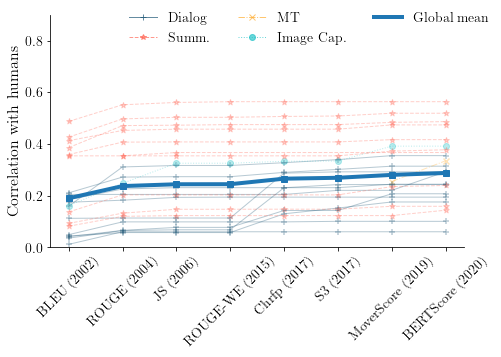

In [30]:
METRIC_NAMES = ['BLEU (2002)', 'ROUGE (2004)', "JS (2006)", "ROUGE-WE (2015)", "Chrfp (2017)", "S3 (2017)", "MoverScore (2019)", "BERTScore (2020)"]    
fig, ax = plt.subplots(1, 1, figsize=(7,5))
all_ys = []
all_ycom = []
color_palette = [
    "#134e6f",
    "#ff6150",
    "#ffa822",
    "#1ac0c6"
]

for i, dataset in enumerate(AVAILBLE_DATASETS):
    # if dataset != 'SUM_EVAL.csv':
    #     continue
    # print(dataset)
    if 'DIALOG' in dataset.upper():
        c = color_palette[0]
        ls = '-'
        marker = '+'
    elif 'TAC' in dataset.upper() or 'SUM' in dataset.upper():
        c = color_palette[1]
        ls = '--'
        marker = '*'
    elif 'MLQE' in dataset.upper():
        c = color_palette[2]
        ls = '-.'
        marker = 'x'
    else:
        c = color_palette[3]
        ls = ':'
        marker = 'o'
    ys= plot_lines(ax, dataset, METRIC_ORDER, color=c, ls=ls, marker=marker)
    all_ys.extend(ys)
    # all_ycom.append(ycom)

Y = np.hstack([all_ys])
ax.errorbar(x=METRIC_ORDER, y=np.nanmean(Y, axis=0), lw=4, linestyle='-', marker='s', color='tab:blue', alpha=1.) 
ax.set_ylim(0., .9)

ax.set_xticks(range(len(METRIC_ORDER)))
ax.set_xticklabels(METRIC_NAMES, rotation=45)
ax.set_ylabel('Correlation with humans')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
patches = [
    Line2D([0], [0], color=color_palette[0], ls='-', marker='+', lw=1, alpha=0.65, label="Dialog"),
    Line2D([0], [0], color=color_palette[1], ls='--', marker='*', lw=1, alpha=0.65, label="Summ."),
    Line2D([0], [0], color=color_palette[2], ls='-.', marker='x', lw=1, alpha=0.65, label="MT"),
    Line2D([0], [0], color=color_palette[3], ls=':', marker='o', lw=1, alpha=0.65, label="Image Cap."),
    Line2D([0], [0], color='tab:blue', ls='-', lw=4, alpha=1, label="Global mean"),
]
fig.legend(handles=patches, loc='upper right', ncol=3, frameon=False)
fig.tight_layout(pad=1)
# fig.savefig("fig1.pdf")

## Figure 2

In [9]:
def compute_system_tau(df, m_a, m_b, metric='tau'):
    m_a_agg = df[m_a].groupby('System').mean().values
    m_b_agg = df[m_b].groupby('System').mean().values
    if metric == 'tau':
        return (1 - stats.kendalltau(m_a_agg, m_b_agg)[0]) / 2.
    elif metric == 'rho':
        return stats.spearmanr(m_a_agg, m_b_agg)[0]
    return stats.pearsonr(m_a_agg, m_b_agg)[0]

def compute_instance_tau(df, m_a, m_b, metric='tau'):
    corr = []
    for (_, df_a),(_,df_b) in zip(df[m_a].groupby(level=0), df[m_b].groupby(level=0)):
        if metric == 'tau':
            corr.append((1 - stats.kendalltau(df_a.values, df_b.values)[0])/2.)
        elif metric == 'rho':
            corr.append(stats.spearmanr(df_a.values, df_b.values)[0])
        else:
            corr.append(stats.pearsonr(df_a.values, df_b.values)[0])
    
    return np.nanmean(corr)

In [10]:
def pairwise_complementarity_matrix(df, set_metrics, metric='tau', level='instance'):
    n = len(set_metrics)
    sim_mat = np.zeros((n, n))
    for i, m_a in enumerate(set_metrics):
        for j, m_b in enumerate(set_metrics):
            if i < j:
                continue
            if i == j:
                sim_mat[i][j] = 0.
                continue
                
            sim = None
            if level == 'system':
                sim = compute_system_tau(df, m_a, m_b, metric)
            else:
                sim = compute_instance_tau(df, m_a, m_b, metric)
            
            sim_mat[i][j] = sim
            sim_mat[j][i] = sim
    return sim_mat

In [12]:
sim_pair_dicts = {}
set_metrics_dicts = {}
for dataset in AVAILBLE_DATASETS:
    df = load_csv(dataset)
    humans = [v for v in df.columns if v.startswith('H:')]
    automatic = [v for v in df.columns if not v.startswith('H:')]
    set_metrics = humans + automatic
    sim_pair_dicts[dataset] = pairwise_complementarity_matrix(df, set_metrics)
    set_metrics_dicts[dataset] = set_metrics

In [16]:
def plot_heatmap(ax, heatmap, set_metrics_names, cbar_on=True):
    n_humans = sum([m.startswith('H:') for m in set_metrics_names])
    
    set_metrics = []
    for i, m in enumerate(set_metrics_names):
        if m.startswith('H:'):
            new_m = f'H:{i}'
        else:
            new_m = f'A:{i-n_humans}'
        set_metrics.append(new_m)
        
    im = ax.imshow(heatmap, cmap="YlGn", vmin=0, vmax=.6)
    if cbar_on:
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel("Complementarity", rotation=-90, va="bottom")
    
    ax.set_xticks(np.arange(len(set_metrics)), labels=['']*len(set_metrics))
    ax.set_yticks(np.arange(len(set_metrics)), labels=set_metrics)
    
    ax.hlines(n_humans-0.5, xmin=-0.5, xmax=len(set_metrics)+0.5, lw=2, ls='--', color='tab:red')
    ax.vlines(n_humans-0.5, ymin=-0.5, ymax=len(set_metrics)+0.5, lw=2, ls='--', color='tab:red')
    
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    ax.spines[:].set_visible(False)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    return im

/var/folders/lr/_9h15b252l5b5y3dkq6ngvpw0000gp/T/ipykernel_38054/2242241331.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1.0)


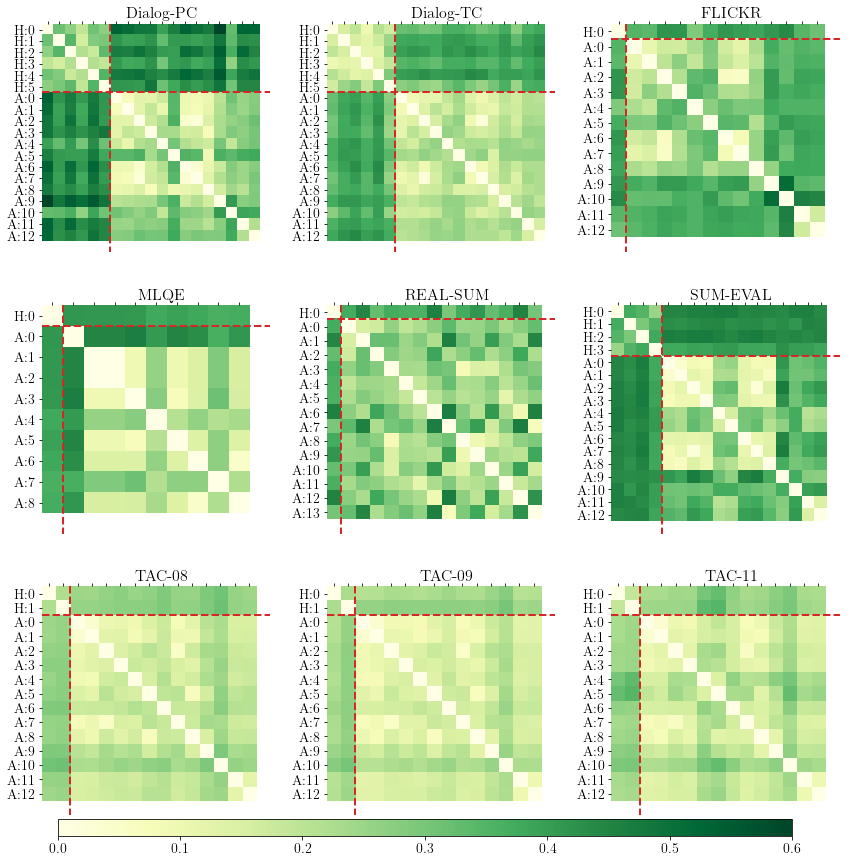

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(12,12))
for dataset, ax in zip(AVAILBLE_DATASETS, axes.flat):
    res = sim_pair_dicts[dataset]
    set_metrics = set_metrics_dicts[dataset]
    im = plot_heatmap(ax, res, set_metrics, cbar_on=False)
    ax.title.set_text(normalize_dataset_names(dataset))
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([.07, 0.02, .85, 0.02])

cbar = fig.colorbar(im, cax=cbar_ax, cmap="YlGn", orientation='horizontal')

fig.tight_layout(pad=1.0)
# fig.savefig('complementarity.pdf')#, pad_inches=0.1)

## Figure 3

In [34]:
def human_improvements(key):
    df = datasets[key]
    humans = [col for col in df.columns if col.startswith('H:')]
    other = [col for col in df.columns if not col.startswith('H:')]
    
    auto_h = []
    h_h = []
    auto_and_h_h = []
    for h in humans:
        auto_h.append(fit(df, other, h))
        
        if len(humans) == 1:
            break
            
        other_h = [h_m for h_m in humans if h_m != h]
        h_h.append(fit(df, other_h, h))
        
        auto_and_h_h.append(fit(df, other + other_h, h))
    return {'A:H': auto_h,
            'H:H': h_h,
            'A+H:H': auto_and_h_h}

In [35]:
analysis_with_humans = {}
for k in AVAILBLE_DATASETS:
    analysis_with_humans[k] = human_improvements(k)

In [38]:
def grouped_bar_plot(ax, res):
    
    d = [k for k, v in res.items() if v['H:H']]
    
    auto, human, auto_human = [], [], []
    auto_err, human_err, auto_human_err = [], [], []
    for k in d:
        auto.append(np.mean(res[k]['A:H']))
        auto_err.append(np.std(res[k]['A:H']))
        
        human.append(np.mean(res[k]['H:H']))
        human_err.append(np.std(res[k]['H:H']))
        
        auto_human.append(np.mean(res[k]['A+H:H']))
        auto_human_err.append(np.std(res[k]['A+H:H']))
    
    width = .3
    x = np.arange(len(d))
    rects1 = ax.bar(x - width, auto, width, yerr=auto_err, color='tab:grey', alpha=0.8)
    rects2 = ax.bar(x, human, width, yerr=human_err, color='tab:blue', alpha=0.8)
    rects3 = ax.bar(x + width, auto_human, width, yerr=auto_human_err, color='tab:red', alpha=0.8)
    
    ax.set_xticks(range(len(d)))
    ax.set_xticklabels([normalize_dataset_names(dd) for dd in d], rotation=45)
    ax.set_ylabel('Correlation with humans')
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # rects1 = ax.bar(x - width/2, auto_means, width)
    # rects2 = ax.bar(x + width/2, h_means, width)

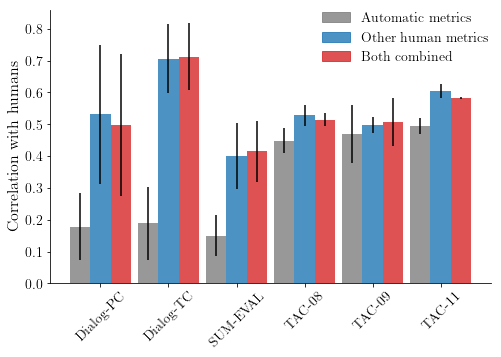

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
grouped_bar_plot(ax, analysis_with_humans)
patches = [mpatches.Patch(color='tab:grey', alpha=0.8, label="Automatic metrics"),
           mpatches.Patch(color='tab:blue', alpha=0.8, label="Other human metrics"),
           mpatches.Patch(color='tab:red', alpha=0.8, label="Both combined")]
fig.legend(handles=patches, loc='upper right', ncol=1, frameon=False)
fig.tight_layout(pad=1)
# fig.savefig("human_auto.pdf")